# **Section 1: Problem Description**

## 1. Problem Statement
* Clearly define the image classification task
* Describe the motivation for GPU acceleration

#### Clearly define the image classification task
- The core objective of this project is to build an Autoemcoder-based unsupervised feature learning system for image classification on the CIFAR-10 dataset.This process is implemented in a two-stage pipeline:
- Stage 1 - Unsupervised Feature Learning:
  - Train a Convolutional Autoencoder to reconstruct $32 \times 32 \times 3$ input images from CIFAR-10.
  - The Autoencoder learns to compress the image into an 8,192-dimensional feature representation.
  - The network is trained to minimize the reconstruction error (MSE Loss), forcing the encoder to capture essential visual patterns (edges, textures, shapes) without using any class labels
- Stage 2 - Supervised Classification:
  - Use the trained encoder to extract features for all images. Then, a Support Vector Machine (SVM) classifier is trained on these learned features using the class labels.
  - The final performance is evaluated on the test set.
- Dataset and Performance TargetDataset: CIFAR-10 (60,000 total images, $32 \times 32$ pixels, 10 classes).
- Target Accuracy: The project aims for a Test classification accuracy of 60-65%.

#### Describe the motivation for GPU acceleration
- The primary motivation for implementing the project's core components (Autoencoder training and feature extraction) in CUDA is to overcome CPU performance limitations and meet aggressive time targets.
- Training the Convolutional Autoencoder is a computationally intensive task that can take hours on a CPU. The goal is to reduce the Autoencoder training time to less than 10 minutes on the GPU.
- Through systematic optimization, the project aims to accelerate the autoencoder dramatically, targeting a GPU speedup over CPU of >20x.
- The process of running the encoder to extract features for all 60,000 images must also be highly optimized, with a target Feature extraction time of less than 20 seconds.
- The project's main focus is on implementing and optimizing the autoencoder training and inference in CUDA, while utilizing existing optimized libraries (like LIBSVM) for the subsequent SVM classification step.

## 2. CIFAR-10 Dataset Overview
* Dataset specifications (size, classes, split)
* Show sample images from each class (use visualization)
* Explain data preprocessing steps (normalization, format)

#### **Dataset Specifications**

The dataset is prized for its manageable size, allowing researchers to quickly iterate on different neural network architectures.

| Feature | Specification |
| --- | --- |
| **Total Images** | 60,000 |
| **Image Resolution** | 32 x 32 pixels |
| **Color Channels** | 3 (RGB) |
| **Format** | Color (uint8) |
| **File Size** | ~162 MB (binary version) |

#### **Classes**

The dataset contains 10 distinct classes, with exactly 6,000 images per class. The classes are completely mutually exclusive .

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

#### **Data Split**

The 60,000 images are split into two main subsets to ensure standardized benchmarking:

* **Training Set (50,000 images):** Divided into 5 training batches, each containing 10,000 images. While the total training set is balanced (5,000 images per class), individual batches may have a slightly different distribution.
* **Test Set (10,000 images):** Contains exactly 1,000 randomly selected images from each class.

#### **Sample Image**

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
!tar -xzf cifar-10-binary.tar.gz
!ls cifar-10-batches-bin/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def load_all_from_bin(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    data = data.reshape(-1, 3073)
    labels = data[:, 0]
    images = data[:, 1:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images, labels

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

all_imgs, all_lbls = load_all_from_bin('./cifar-10-batches-bin/data_batch_1.bin')

unique_indices = [np.where(all_lbls == i)[0][0] for i in range(10)]

imgs = all_imgs[unique_indices]
lbls = all_lbls[unique_indices]

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.title(f"{class_names[lbls[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### **Data preprocessing steps**

There are three main stages

**1. Structural Parsing and Memory Management**

The process begins by reading the raw binary files into system memory to separate the labels from the pixel data.

* Each image in the CIFAR-10 binary format is stored as a 3073-byte record, where the first byte is the label and the remaining 3072 bytes are the image data.
* The code iterates through the raw buffer, extracting the first byte of every record and storing it into an integer array (`labels`).
* The pixel data (3072 bytes per image) is copied into a separate `raw_images` buffer, effectively stripping the labels to prepare for batch processing on the GPU.

**2. GPU-Accelerated Normalization**

The core of the preprocessing is the normalization step, which shifts pixel values from an integer range to a floating-point range for better gradient flow during training.

* Converts the input `uint8` (0–255) pixel values into `float32`.
* A specific GPU function, `normalizeKernel`, is launched where each thread processes a single pixel to compute output[idx] = input[idx] / 255.0f.
* This result ensures all input features are scaled to the range [0.0, 1.0], which is verified at the end of the loading process by calculating the minimum and maximum values in the final array.
* If a CUDA-enabled device is not detected, the code includes a nested loop fallback to perform the same division on the CPU.

**3. Dataset Organization and Shuffling**

Once the data is normalized, it is organized into a structured `Dataset` object for easier handling by the training loop.

* The `shuffle_dataset` function uses a Mersenne Twister random number generator (`mt19937`) to shuffle an index vector. It then rearranges the image and label memory based on these random indices to ensure the model does not learn the order of the classes.
* The `create_minibatches` function partitions the full dataset into smaller, fixed-size `Dataset` objects (batches). This allows the training process to perform weight updates more frequently and manage memory more efficiently.

## 3. Autoencoder Architecture
* Describe the network architecture with a diagram
* Specify layer dimensions and transformations
* Explain the encoder-decoder structure and latent representation
* Include architecture visualization

#### **Network Architecture**

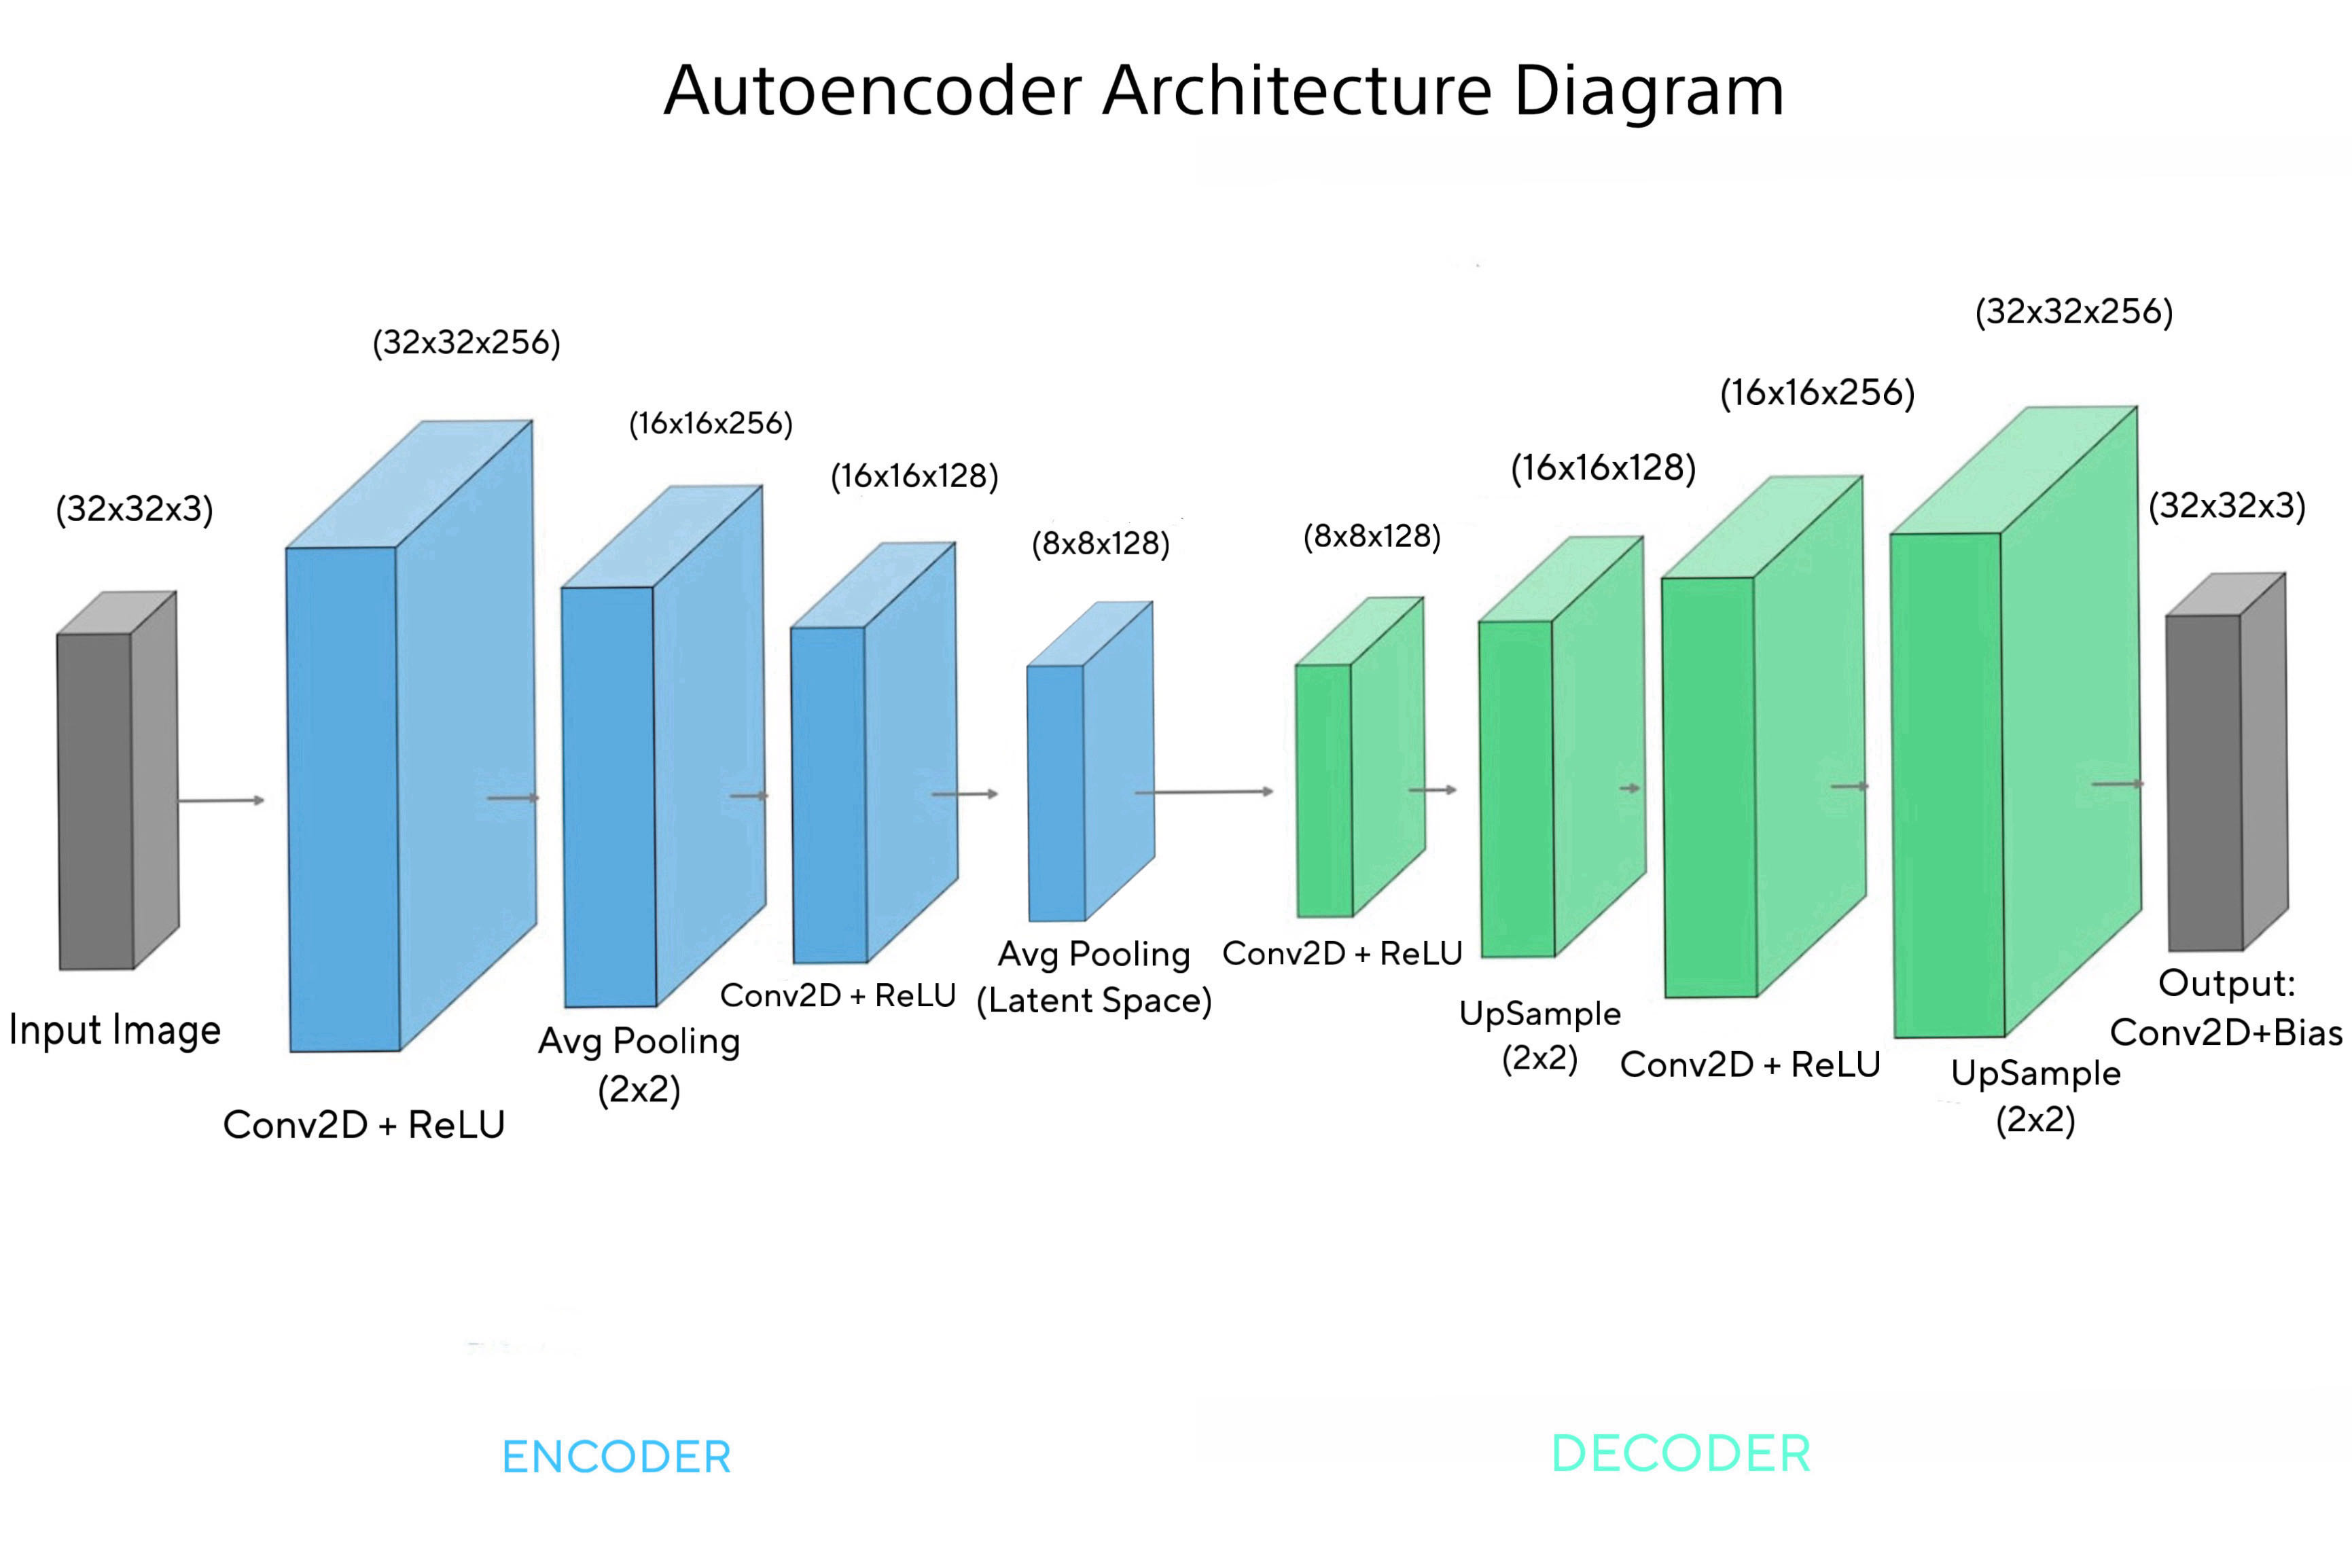

#### **Encoder Structure**

* **Goal**: The encoder reduces the spatial dimensions (width and height) of the input image while increasing feature depth to extract high-level patterns.
* **Spatial Compression**: It uses a sequence of convolutional and **max pooling** layers to shrink the input. The code explicitly implements `cpu_max_pooling`, which reduces the width and height by a factor of 2 at each stage.
* **Layer 1**: Input  Conv  ReLU  Max Pool (Size ).
* **Layer 2**: Input  Conv  ReLU  Max Pool (Size ).



#### **Latent Representation**

* **Definition**: The latent representation is the output of the second encoder layer, serving as the compressed "bottleneck" of the network.
* **Dimensions**: The spatial resolution is reduced to  of the original input, containing the most essential features in a condensed format.

#### **Decoder Structure**

* **Goal**: The decoder attempts to reconstruct the original input from the latent representation by reversing the compression.
* **Spatial Expansion**: It utilizes upsampling layers to restore spatial dimensions. Each upsampling stage doubles the width and height, effectively undoing the compression performed by the pooling layers.
* **Layer 1**: Latent  Conv  ReLU  Upsample (Size ).
* **Layer 2**: Input  Conv  ReLU  Upsample (Size ).



#### **Layer Dimensions and Transformations**

The CPU implementation defines several core transformations that modify data dimensions as it passes through the network.

| Layer Type | Forward Transformation Logic | Spatial Change |
| --- | --- | --- |
| **Conv2D** | Applies filters to extract features; maintains spatial dimensions via zero-padding logic implicitly handled in the loops. | No Change |
| **ReLU** | Element-wise activation: . | No Change |
| **Max Pooling** | A  window selects the **maximum** value to propagate, discarding the rest. | Dimension  |
| **Upsample** | A single pixel is duplicated into a  output block (Nearest Neighbor interpolation). | Dimension  |

#### **Architecture Visualization**

The overall architecture follows a symmetrical flow of compression and expansion:

1. **Input Layer**: Original image data ().
2. **Encoder Stages**:
* `cpu_conv2D`  `cpu_relu`
* `cpu_max_pooling` (Reduces  by half).


3. **Latent Representation**: The final compressed feature map ().
4. **Decoder Stages**:
* `cpu_conv2D`  `cpu_relu`
* `cpu_upsampling` (Doubles ).


5. **Output Layer**:
* `cpu_conv2D`  `cpu_add_bias` (Reconstructed data matching input size).



## 4. Project Objectives
* Performance goals (training time, speedup targets, accuracy)
* Technical learning objectives
* Success criteria

#### Performance Goals

- These are the required numerical targets you must achieve through systematic optimization in CUDA. Achieving these goals is the primary measure of success for the project's performance aspect.

| Metric | Target |
| :--- | :--- |
| **Autoencoder training time** | **<10 minutes** |
| **Feature extraction time** | **<20 seconds** (for all 60,000 images)  |
| **Test classification accuracy** | **60-65%**  |
| **GPU speedup over CPU** | **>20x**  |





#### **Technical Learning Objectives**

- The project serves as an intensive exercise in **parallel programming** and deep learning implementation by requiring implementation from the ground up.

* Learn to design, implement, and debug efficient parallel kernels for deep learning primitives, including Convolution , ReLU , Max Pooling , and UpSampling.
* Understand and apply advanced optimization techniques (e.g., Shared Memory Tiling, Kernel Fusion, Memory Coalescing, Multi-Stream Pipeline) to maximize GPU efficiency and memory bandwidth utilization.
* Gain a comprehensive understanding of the Autoencoder architecture (forward and backward passes) and implement the complete network from scratch.
* Successfully integrate the high-speed CUDA-accelerated feature extractor with a standard machine learning library (LIBSVM) to complete the two-stage feature learning and classification pipeline.

#### **Success Criteria**

Project success is evaluated by the functional completeness of the pipeline and the achievement of the specified targets.

1. All GPU layer implementations must be verified against the CPU baseline implementation to ensure mathematical accuracy.
2. All quantitative targets for training time, feature extraction time, and GPU speedup must be met or exceeded.
3.  The final classification accuracy on the test set must fall within the target range of **60-65%**, validating the quality of the learned features.
4.  Deliver a detailed, executable Jupyter Notebook report documenting the progressive optimization phases, profiling analysis, results, and key lessons learned.

# Section 2: Implementation Phases

## Phase 2.1: CPU Baseline Implementation

### Objectives:
* What you aimed to achieve in this phase
* Why this phase is necessary

#### **What you aimed to achieve in this phase**
- The aim of Phase 2.1 is to build a complete, functional, and measurable CPU implementation of the entire data pipeline and neural network architecture.
- Data Pipeline Completion: Successfully implement the data loading process for CIFAR-10, including parsing the binary format, normalizing pixel values from [0,255] to [0,1], implementing batch generation, and adding data shuffling.
- CPU Layer Implementation: Create CPU versions of all necessary operations for the Autoencoder: Convolution (Conv2D), ReLU Activation, Max Pooling, Upsampling (Nearest Neighbor interpolation), and MSE Loss.
- Full Autoencoder Functionality: Encapsulate the network architecture into an Autoencoder class, implement weight initialization, manage memory for intermediate activations, and develop the full Forward Pass and Backward Pass (including gradient calculation and weight update logic).
- Establish Baseline Performance: Run the full CPU training loop for a set number of epochs to measure and track the time per epoch and the total training time, thereby establishing the crucial baseline performance.



#### **Why This Phase is Necessary**
- The CPU baseline is not just an intermediary step; it is critical for validating the entire project moving forward.
- The CPU implementation serves as the indispensable "gold standard" reference. Before any optimization, the complex GPU kernels developed in Phase 2 must be verified against the CPU output to ensure they are mathematically accurate and producing the correct results for the forward and backward passes.
- The measured CPU training time is the benchmark against which all subsequent GPU optimization phases are measured. Without a verifiable CPU baseline, you cannot calculate the required >20× speedup target.
- It allows for debugging the high-level neural network logic (weight updates, backpropagation chain, hyperparameter settings) in a familiar CPU environment before dealing with the added complexity of parallel execution and GPU memory management (host/device transfers).

### Implementation Details:
* Data Pipeline: How you loaded and pre-processed CIFAR-10 data
* Layer Implementations: Brief description of each layer (Conv2D, ReLU,
MaxPool, Upsample)
* Training Loop: How you structured the training process
* Key Code Snippets: Show 2-3 critical functions (e.g., convolution function
signature and main loop structure)

#### **Data Pipeline:**
- The data is loaded from the standard CIFAR-10 binary format, where each record contains 1 byte for the label followed by 3072 bytes for the image (32 (width) x 32 (height) x 3 (depth)).
  - Training Data: Loaded from five separte batch files (data_batch_1.bin through data_batch_5.bin), totaling 50.000 samples.
  - Test Data: Loaded from a single test_batch.bin file, totaling 10.000 samples.
  - Dataset Structure: The loaded and pre-processed data is stored in a Dataset object, which manages the image data and labels using `unique_ptr` for memory safety.
- The raw unsigned char pixel values, which range from [0,255], are normalized to float values in the range [0,1].
  - CPU Normlization (Fallback): If CUDA is unavailable, the normalization is performed on the CPU using a standard loop:
  $\text{output}[\text{idx}] = \text{input}[\text{idx}] / 255.0\text{f}$.
  - CUDA Normalization (Default): If a CUDA device is detected, the normalization is offloaded to the GPU for parallel processing.
    - Raw image data is copied to the device
    - A CUDA kernel is launched to perform the $\text{value} / 255.0\text{f}$ calculation in parallel across all pixels .
    - The resulting normalized float data is copied back to the host memory.
- Two ultilities are available to manage the data during the training process:
  - The `shuffle_dataset` function shuffles the order of images and their corresponding labels by shuffling a list of indices and then copying the data based on the index order.
  - The `create_minibatches` function splits the full Dataset into a vector of smalles Dataset objects for efficient stochastic training.

#### Layers Implementations

**I. Forward Pass Layers (Inference)**

These functions process the input data to generate predictions or latent representations.

**1. Conv2D (Convolution)**

* **Goal**: Extracts features by sliding filters over the input image.
* **Mechanism**: Iterates through every pixel and every filter. It calculates the weighted sum (dot product) of the filter weights and the corresponding input patch.
* **Padding**: Simulates "same" padding by checking boundary conditions (`if (row < 0 || row >= height) continue`) to keep output dimensions consistent with input.

**2. Add Bias**

* **Goal**: Shifts the output of the convolution by adding a learnable bias parameter.
* **Mechanism**: Adds a specific bias value to every pixel in a specific depth channel. `out[i] = in[i] + bias_val`.

**3. ReLU (Activation)**

* **Goal**: Introduces non-linearity by removing negative values.
* **Mechanism**: Performs element-wise comparison: .

**4. Max Pooling (Downsampling)**

* **Goal**: Reduces spatial dimensions () by half to compress data and keep prominent features.
* **Mechanism**: Scans  regions of the input and selects the **maximum** value to pass to the output. `out_offset[...] = max_val`.

**5. Upsampling (Upsampling)**

* **Goal**: Doubles the spatial dimensions () to reconstruct the image.
* **Mechanism**: Takes a single pixel value and duplicates it into a  block in the output (Nearest Neighbor interpolation).


**II. Loss Calculation**

**6. MSE Loss**

* **Goal**: Measures how far the model's output is from the original input.
* **Mechanism**: Calculates the Mean Squared Error: .


**III. Backward Pass Layers (Training)**

These functions calculate gradients to update weights and propagate errors.

**7. MSE Gradient**

* **Goal**: Starts backpropagation by calculating the derivative of the loss.
* **Mechanism**: Computes gradient per pixel: .

**8. ReLU Backward**

* **Goal**: Passes gradients through the activation function.
* **Mechanism**: Acts as a gate. If the original input was positive (`in > 0`), it passes the gradient (`d_out`) through. If negative, it blocks the gradient (sets to 0).

**9. Max Pooling Backward**

* **Goal**: Routes gradients back through the max pooling layer.
* **Mechanism**: Re-scans the input to find which pixel was the "winner" (max value). The gradient is added **only** to that specific index (`d_in_offset[max_idx] += grad`), while neighbors get 0.

**10. Upsampling Backward**

* **Goal**: Handles gradients for the upsampling layer.
* **Mechanism**: Since one input pixel created 4 output pixels (), this sums the gradients from those 4 output pixels to compute the single input gradient.

**11. Bias Gradient**

* **Goal**: Computes gradients for bias updates.
* **Mechanism**: Sums the gradients (`d_out`) across all spatial pixels () and all images in the batch () for each specific channel.

**12. Conv2D Gradient (for Weights)**

* **Goal**: Computes how much to adjust the filters (`d_filter`).
* **Mechanism**: Convolves the input features (`in`) with the output gradients (`d_out`) to find the correlation, which indicates how the weights should change.

**13. Conv2D Backward Input (for Inputs)**

* **Goal**: Propagates the error signal (`d_in`) to the previous layer.
* **Mechanism**: Reverses the convolution. It multiplies output gradients (`d_out`) by the filter weights (`w`) and accumulates the result into the input gradient map (`d_in`).

**14. Update Weight**

* **Goal**: Applies the calculated gradients to the weights.
* **Mechanism**: Standard SGD update: .



#### **Training Loop**:

**1. High-Level Training Loop (`fit`)**

This function orchestrates the entire training timeline.

* **Mini-batch Creation**: It splits the entire `dataset` into smaller chunks (`batches`) based on the `batch_size`. This ensures the model updates weights more frequently than once per epoch.
* **Memory Allocation**: Before training starts, it calls `_allocate_output_mem` to create the temporary buffers needed for the intermediate layer outputs (feature maps) and gradients. This is done once per training session to avoid re-allocating memory every iteration.
* **Epoch Loop**:
* Iterates from 1 to `n_epoch`.
* **Batch Loop**: Iterates through every `batch` in the generated list.
* Calls `_fit_batch` to process the data and update weights.
* Accumulates loss and tracks execution time.
* Updates the progress bar.


* **Checkpointing**: If enabled (`checkpoint > 0`), it saves the current model parameters to a binary file (e.g., `cpu_autoencoder_10.bin`).


* **Cleanup**: Calls `_deallocate_output_mem` after the loops finish to free the temporary buffers.

**2. Single Batch Processing (`_fit_batch`)**

This function performs the actual mathematical operations for one step of Gradient Descent.

**A. Forward Pass (Inference)**

* The input `batch` is passed through the encoder:
* `_encode_save_output`: Input  Conv1  MaxPool1  Conv2  MaxPool2 (Latent).


* The latent representation is passed through the decoder:
* `_decode_save_output`: Latent  Conv1  Upsample1  Conv2  Upsample2  Conv3 (Output).


* **Result**: This chain fills all the intermediate buffers (`_out_...`) with activation values needed for gradient calculation.

**B. Loss Calculation**

* Computes the MSE (Mean Squared Error) between the original input (`batch.get_data()`) and the reconstructed output (`res.get_data()`).
* Computes the initial gradient `d_out` (derivative of MSE) to start the backward chain.

**C. Backward Pass (Backpropagation)**
The code manually chains the backward functions in reverse order. For each layer, it typically performs three steps:

1. **Propagate Error (`_backward_input` / `_upsampling_backward` / etc.)**: Calculates `d_in` for the previous layer.
2. **Calculate Weight Gradient (`_grad`)**: Uses the layer's input and the incoming error `d_out` to find how to update the filters.
3. **Update Weights (`_update_weight`)**: Adjusts the filters and biases immediately using the learning rate.

**Sequence of Backward Operations:**

1. **Decoder Layer 3**: Updates `_decoder_bias_3` and `_decoder_filter_3`.
2. **Decoder Layer 2**: Backpropagates through Upsample  ReLU, then updates `_decoder_bias_2` and `_decoder_filter_2`.
3. **Decoder Layer 1**: Backpropagates through Upsample  ReLU, then updates `_decoder_bias_1` and `_decoder_filter_1`.
4. **Encoder Layer 2**: Backpropagates through MaxPool  ReLU, then updates `_encoder_bias_2` and `_encoder_filter_2`.
5. **Encoder Layer 1**: Backpropagates through MaxPool  ReLU, then updates `_encoder_bias_1` and `_encoder_filter_1`.

**Summary Structure**

| Level | Component | Responsibility |
| --- | --- | --- |
| **Outer** | `fit` | Manages Epochs, splits Batches, manages RAM, saves Checkpoints. |
| **Middle** | `_fit_batch` | Runs Forward pass, Loss calc, and orchestrates the Backward chain. |
| **Inner** | `_encode`/`_decode` | Runs the specific layer logic (Conv, ReLU, Pool) to generate output. |
| **Kernel** | `cpu_layers.cpp` | Performs the raw mathematical operations on arrays. |


#### **Key Code Snippets**

1. **Max Pooling Implementation (Downsampling)**
* The `cpu_max_pooling` and `cpu_max_pooling_backward` functions handle the spatial compression in the Encoder and the corresponding gradient routing during training.
* Reduces the image dimensions by half () by selecting the most prominent feature in a  window.
* **Forward Logic**: The code iterates through  blocks. It finds the maximum value within that block and passes only that value to the output.
* **Backward Logic**: Crucially, during backpropagation, the gradient is not split evenly. The code re-scans the input to find the index of the maximum value (`max_idx`) and adds the incoming gradient only to that specific position in the input derivative array (), leaving the non-max neighbors with zero gradient.
```cpp
void cpu_max_pooling(float *in, float *out, int n, int width, int height, int depth) {
  for (int image = 0; image < n; ++image) {
    int offset = image * width * height * depth;
    float *in_offset  = in + offset;
    float *out_offset = out + offset / 4;
    
    for (int d = 0; d < depth; ++d) {
      for (int i = 0; i < height / 2; ++i) {
        for (int j = 0; j < width / 2; ++j) {
          
          float max_val = -FLT_MAX; // Khởi tạo giá trị rất nhỏ

          int neighbors_idx[] = {
            GET_1D_IDX(i * 2,      j * 2,      d, width, height),
            GET_1D_IDX(i * 2,      j * 2 + 1,  d, width, height),
            GET_1D_IDX(i * 2 + 1,  j * 2,      d, width, height),
            GET_1D_IDX(i * 2 + 1,  j * 2 + 1,  d, width, height),
          };

          for (int neighbor : neighbors_idx) {
             if (in_offset[neighbor] > max_val) {
                 max_val = in_offset[neighbor];
             }
          }
          out_offset[GET_1D_IDX(i, j, d, width / 2, height / 2)] = max_val;
        }
      }
    }
  }
}
```
```cpp
void cpu_max_pooling_backward(float *in, float *d_out, float *d_in, int n, int width, int height, int depth) {
  // Reset d_in về 0 trước khi tính toán
  memset(d_in, 0, n * width * height * depth * sizeof(float));

  for (int image = 0; image < n; ++image) {
    int offset = image * width * height * depth;
    float *in_offset    = in + offset;       // Cần input gốc để tìm lại max
    float *d_in_offset  = d_in + offset;
    float *d_out_offset = d_out + offset / 4;

    for (int d = 0; d < depth; ++d) {
      for (int i = 0; i < height / 2; ++i) {
        for (int j = 0; j < width / 2; ++j) {
          
          // 1. Tìm lại vị trí Max trong vùng 2x2
          float max_val = -FLT_MAX;
          int max_idx = -1;

          int neighbors_idx[] = {
            GET_1D_IDX(i * 2,      j * 2,      d, width, height),
            GET_1D_IDX(i * 2,      j * 2 + 1,  d, width, height),
            GET_1D_IDX(i * 2 + 1,  j * 2,      d, width, height),
            GET_1D_IDX(i * 2 + 1,  j * 2 + 1,  d, width, height),
          };

          for (int idx : neighbors_idx) {
            if (in_offset[idx] > max_val) {
              max_val = in_offset[idx];
              max_idx = idx;
            }
          }

          // 2. Chỉ truyền gradient về đúng vị trí Max đó
          if (max_idx != -1) {
            float grad = d_out_offset[GET_1D_IDX(i, j, d, width / 2, height / 2)];
            d_in_offset[max_idx] += grad;
          }
        }
      }
    }
  }
}
```

2. **Upsampling Implementation (Reconstruction)**
* The `cpu_upsampling` and `cpu_upsampling_backward` functions handle the spatial expansion in the Decoder, effectively reversing the pooling operation dimensions.
* **Function Role**: Doubles the image dimensions () to reconstruct the original size.
* **Forward Logic**: Implements "Nearest Neighbor" interpolation. It takes a single pixel value from the input and duplicates it into all 4 positions of the corresponding  block in the output.
* **Backward Logic**: Since one input pixel was responsible for creating four output pixels, the backward pass acts as an accumulator. It sums the gradients from all four corresponding pixels in the output gradient map () to compute the single gradient value for the input ().
```cpp
void cpu_upsampling(float *in, float *out, int n, int width, int height, int depth) {
  for (int image = 0; image < n; ++image) {
    int    offset     = image * width * height * depth;
    float *in_offset  = in + offset;
    float *out_offset = out + offset * 4;
    for (int d = 0; d < depth; ++d) {
      for (int i = 0; i < height; ++i) {
        for (int j = 0; j < width; ++j) {
          float val = in_offset[GET_1D_IDX(i, j, d, width, height)];
          int neighbors_idx[] = {
            GET_1D_IDX(i * 2,     j * 2,      d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2,     j * 2 + 1,  d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2 + 1, j * 2,      d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2 + 1, j * 2 + 1,  d, 2 * width, 2 * height),
          };
          for (int neighbor_idx : neighbors_idx)
            out_offset[neighbor_idx] = val;
        }
      }
    }
  }
}
```
```cpp
void cpu_upsampling_backward(float *d_out, float *d_in, int n, int width, int height, int depth) {
  for (int image = 0; image < n; ++image) {
    int offset = image * width * height * depth;
    float *d_in_offset  = d_in + offset;
    float *d_out_offset = d_out + offset * 4;
    for (int d = 0; d < depth; ++d) {
      for (int i = 0; i < height; ++i) {
        for (int j = 0; j < width; ++j) {
          float sum = 0.0f;
          int neighbors_idx[] = {
            GET_1D_IDX(i * 2,     j * 2,      d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2,     j * 2 + 1,  d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2 + 1, j * 2,      d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2 + 1, j * 2 + 1,  d, 2 * width, 2 * height)
          };
          for (int neighbor_idx : neighbors_idx)
            sum += d_out_offset[neighbor_idx];
          d_in_offset[GET_1D_IDX(i, j, d, width, height)] = sum;
        }
      }
    }
  }
}
```

### Results:
* Training time per epoch and total training time
* Final reconstruction loss
* Sample reconstructed images (show original vs reconstructed)
* Memory usage

In [ ]:
!g++ main.cpp data_loader.cpp cpu_autoencoder.cpp cpu_layers.cpp timer.cpp progress_bar.cpp utils.cpp -std=c++17 -O2 -o cpu_main8.exe

In [ ]:
!cpu_main8.exe

========== LOAD DATASET ==========
Loading training data from ./cifar-10-batches-bin...
  âœ“ Loaded batch 1/1
âœ“ Training data loaded: 10000 samples
  Data range: [0.0000, 1.0000]
Train samples: 10000

========== INIT AUTOENCODER ==========

========== START TRAIN ==========
Training CPU Autoencoder for 20 epochs with batch size 32 and learning rate 0.0010
=======================TRAINING START=======================
Epoch 1:

Batch 000/313 [>                                                 ] (00%)
Batch 001/313 [>                                                 ] (00%) - Loss = 0.7399 - Time = 8.421s
Batch 002/313 [>                                                 ] (01%) - Loss = 0.4602 - Time = 28.047s
Batch 003/313 [>                                                 ] (01%) - Loss = 0.3533 - Time = 48.400s
Batch 004/313 [>                                                 ] (01%) - Loss = 0.3019 - Time = 1m 8s
Batch 005/313 [>                                                 ] (02%) -

In [ ]:
!g++ image.cpp data_loader.cpp cpu_autoencoder.cpp cpu_layers.cpp utils.cpp progress_bar.cpp timer.cpp -std=c++17 -O2 -o visualize5


In [ ]:
!visualize5

Model loaded from ./output3/cpu_autoencoder_.bin
Loading training data from ./cifar-10-batches-bin...
  âœ“ Loaded batch 1/1
âœ“ Training data loaded: 10000 samples
  Data range: [0.0000, 1.0000]
Recon value range: 0.000000 -> 1.000000
 Saved 8 original + reconstructed CIFAR images


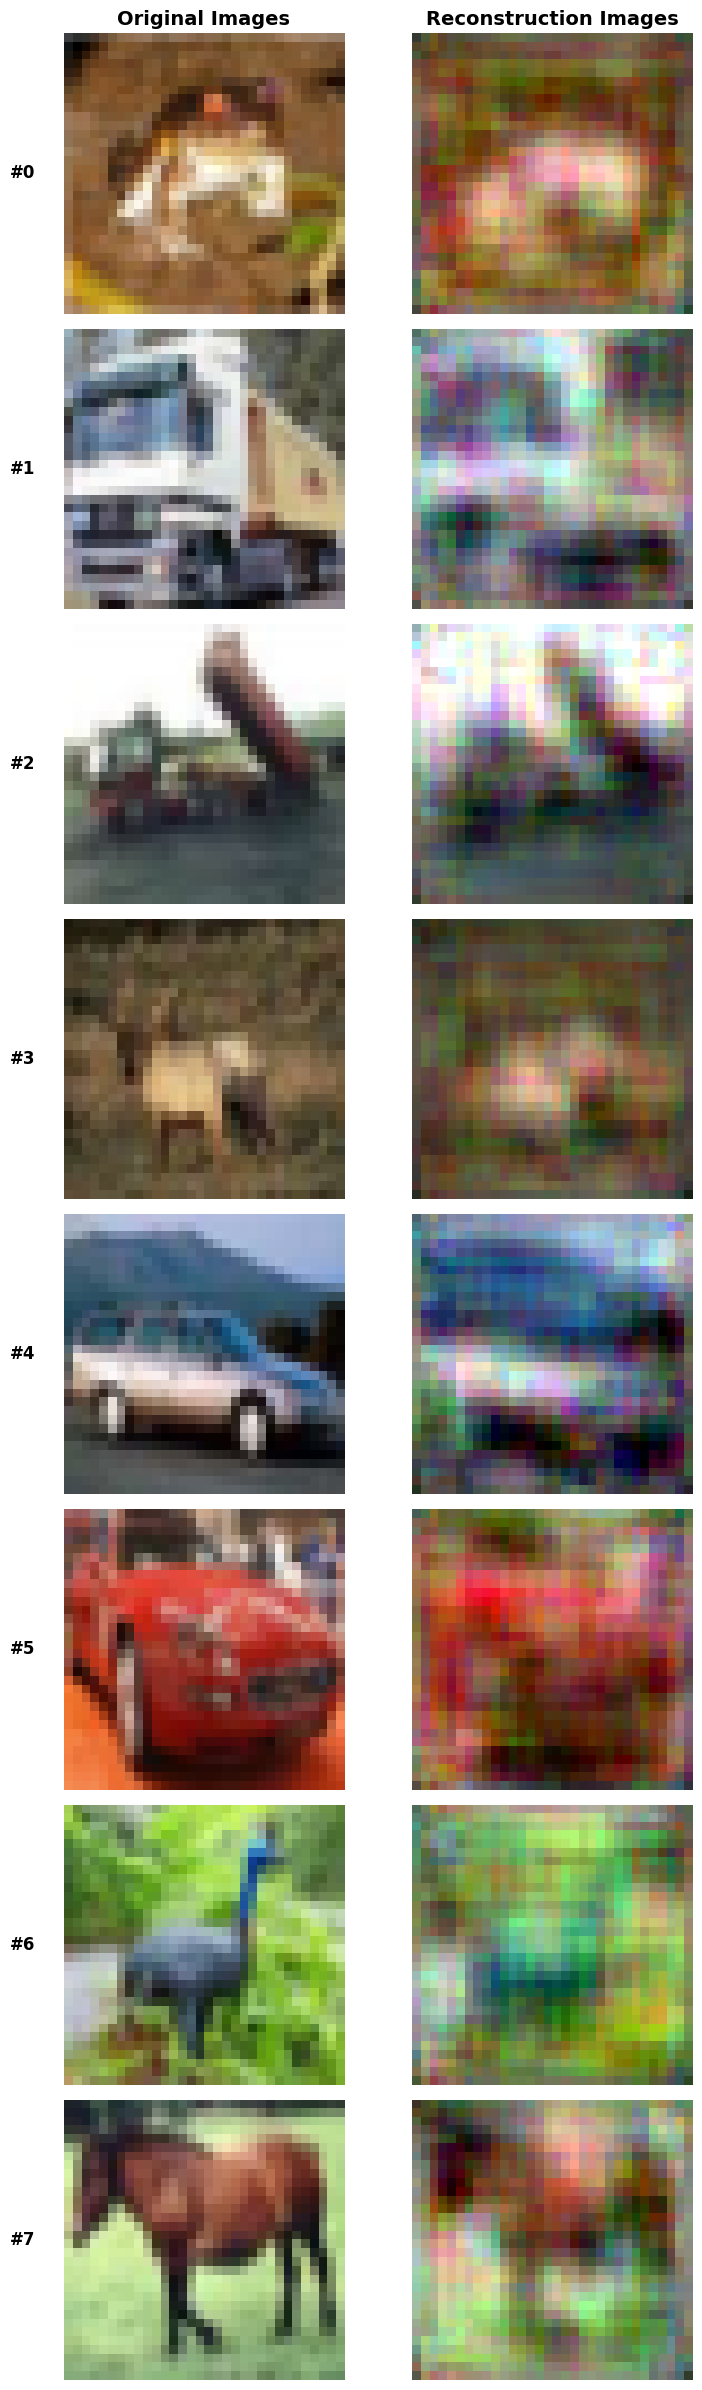

In [2]:
import matplotlib.pyplot as plt
import cv2
import os

folder_path = '.'

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8, 24))

for i in range(8):
    orig_filename = f"orig_{i}.ppm"
    recon_filename = f"recon_{i}.ppm"

    orig_full_path = os.path.join(folder_path, orig_filename)
    recon_full_path = os.path.join(folder_path, recon_filename)

    img_orig = cv2.imread(orig_full_path)
    img_recon = cv2.imread(recon_full_path)
    if img_orig is None:
        print(f"Không tìm thấy file: {orig_full_path}")
        continue
    if img_recon is None:
        print(f"Không tìm thấy file: {recon_full_path}")
        continue

    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_recon = cv2.cvtColor(img_recon, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img_orig)
    axes[i, 0].axis('off') # Tắt trục tọa độ

    axes[i, 1].imshow(img_recon)
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 0].set_title("Original Images", fontsize=14, fontweight='bold')
        axes[i, 1].set_title("Reconstruction Images", fontsize=14, fontweight='bold')

    axes[i, 0].text(-0.1, 0.5, f"#{i}", transform=axes[i, 0].transAxes,
                    fontsize=12, va='center', ha='right', fontweight='bold')

plt.tight_layout()
plt.show()



| Metric | Value |
| :--- | :--- |
| **Training time per epoch** | ~1 hour 40 minutes 39 seconds  |
| **Total training time** | 16 hours 22 minutes 04 seconds = 58924 seconds (for all 10,000 images)  |
| **Final loss** | 0.0148  |
| **Memory usage** | 270MB  |

### Key Takeaways:
* What did you learn about the algorithm?
* What insights guided your GPU implementation?

#### **What did you learn about the algorithm?**
- The algorithm follows a mirrored structure where the Encoder reduces spatial dimensions (Width/Height) by 4x through two pooling stages, while the Decoder restores them using two upsampling stages.
- By reducing the  dimensions while modifying the depth (channels), the algorithm forces the network to learn only the most essential features in the "bottleneck" layer.
- The algorithm relies on the Chain Rule of calculus. Error gradients are calculated at the output and propagated backward. Each layer calculates its own weight updates before passing the "delta" (error) to the previous layer.




#### **What insights guided your GPU implementation?**
On the CPU, convolution requires a deeply nested 6-level loop (Batch  Depth  Height  Width  Filter Window) that processes one pixel at a time.

- The GPU implementation flattens these spatial loops by mapping each output pixel and filter to a unique thread in a 3D grid.
- This allows the hardware to calculate thousands of pixels simultaneously rather than iterating through them one by one.

In the backward pass (gradient calculation), a "many-to-one" update problem occurs because many different input pixels contribute to the gradient of a single filter weight.

- While the CPU version simply uses a standard `+=` operator because it is single-threaded, the GPU version must use `atomicAdd`.
- This ensures that when multiple parallel threads attempt to update the same filter weight simultaneously, the updates are synchronized and no data is lost to race conditions.

Calculating the Mean Squared Error (MSE) loss requires summing values across the entire dataset to get a single average.

- Performing thousands of global `atomicAdd` operations would create massive memory bandwidth congestion. Instead, the implementation utilizes **Shared Memory** to perform block-level reductions.
- By performing most of the summation inside the fast, on-chip shared memory and only writing to global memory once per block, the implementation drastically reduces bandwidth overhead.

## Phase 2.2: GPU Basic Implementation

### Objectives:
* Port CPU code to GPU with basic parallelization
* Verify correctness of GPU kernels
* Establish baseline GPU performance

### Implementation Details:
* Parallelization Strategy: How you mapped operations to GPU threads
* Kernel Designs:
  * Convolution kernel: thread-to-output mapping
  * Pooling kernel: how threads handle 2×2 windows
  * Other kernels (ReLU, upsampling)
* Memory Management: Device memory allocation strategy
* Key Code Snippets: Show kernel signatures and launch configurations

#### **Parallelization Strategy**

**1. Spatial and Channel Mapping**

While the CPU version uses nested `for` loops to iterate through height, width, and filters, the GPU version maps these dimensions directly to the CUDA grid:

* **X and Y Dimensions:** These are mapped to the image **Width** and **Height**. Each thread handles the computation for a specific pixel coordinate $(x, y)$ in the output feature map.
* **Z Dimension:** This is mapped to the **Filters** (output depth) or **Input Depth**. This allows the GPU to compute all feature maps for a given spatial location in parallel.
* **Linear Indexing:** To access the flattened memory buffers, a macro `GET_1D_IDX` is used to translate 3D logic coordinates into a 1D memory address.

**2. Thread-to-Output Mapping**

The core strategy for operations like Convolution, Pooling, and Upsampling is a **thread-to-output** assignment:

* **Convolution:** Each thread $(x, y, f)$ calculates the weighted sum for exactly one pixel in one output filter. It loops through the small $3 \times 3$ filter window internally, but the heavy lifting of processing thousands of pixels and hundreds of filters happens across the grid.
* **Pooling:** Each thread is assigned to one pixel in the reduced-size output. It fetches the $2 \times 2$ neighborhood from the input, calculates the average, and writes the result.
* **Upsampling:** A single thread reads a value from the input and "broadcasts" it to four corresponding locations in the expanded output buffer.

**3. Batch Processing Logic**
* The CPU (Host) iterates through the batch size n.
* For each image in the batch, the GPU kernel is launched with a calculated memory offset. This ensures high parallelism within each image while keeping the memory management and indexing logic predictable for the developer.

**4. Gradient Accumulation and Reduction**

During backpropagation, the mapping strategy adapts to handle many-to-one updates:

* In the Convolution Gradient kernel, many threads (representing different image pixels) contribute to the update of a single filter weight. The code uses `atomicAdd` to ensure these updates are synchronized and no data is lost to race conditions.
* **Shared Memory Reduction:** For calculating the Mean Squared Error (MSE), the strategy uses `__shared__` memory within blocks. Threads first sum their local values in high-speed shared memory before a single thread updates the global total, significantly reducing the pressure on the global memory bus.

#### **Kernel Designs**

**Convolution Kernel: Thread-to-Output Mapping**

The `gpu_conv2D_kernel` is designed to maximize spatial parallelism by assigning each output pixel to a unique GPU thread.

* Each thread identifies its position in the output feature map using its 3D coordinates $(x, y, f)$, where x and y are spatial dimensions and f is the filter index.
* Every thread performs a nested loop over the filter's width and height, and across all input depths, to calculate the weighted sum for its specific pixel.
* The kernel includes conditional logic to check if a neighbor is within image bounds; if not, it skips the calculation, effectively implementing implicit zero-padding.
* The kernel is launched inside a host-side loop that iterates through the batch, calculating the necessary memory offsets for each image.

**Pooling Kernel: 2x2 Window Handling**

The `gpu_avg_pooling_kernel` handles spatial downsampling by mapping threads to the reduced output dimensions.

* Each thread is assigned to one pixel in the output feature map, which corresponds to a $2 \times 2$ window in the input feature map.
* The thread fetches the four neighboring pixels $(in\_y, in\_x), (in\_y, in\_x + 1), (in\_y + 1, in\_x), (in\_y + 1, in\_x + 1)$ from the input.
* It sums these four values and divides by **4.0f** to produce the average value, then writes it to the output buffer.


**Other Kernels: ReLU and Upsampling**

These kernels focus on element-wise transformations or spatial expansion.

**1**. ReLU (Activation Function)

* The `gpu_relu_kernel` is a simple 1D parallel sweep where each thread processes one element of the data.
* It applies the function $f(x) = \max(0, x)$ using the CUDA-optimized `fmaxf(0.0f, in[idx])` function.

**2**. Upsampling (Spatial Expansion)

The `gpu_upsampling_kernel` maps threads to the smaller input dimensions.
* Each thread reads a single value from the input and "broadcasts" it to a $2 \times 2$ block (four pixels) in the larger output tensor.
* The corresponding `gpu_upsampling_backward_kernel` reverses this by having one thread sum the gradients from the $2 \times 2$ output window and pass that sum back to the input gradient.


#### **Memory Management**

**1. Device Memory Allocation Strategy**
* Model weights (filters) and biases for both the encoder and decoder are allocated on the GPU and persist throughout the training session.
* The `Gpu_Autoencoder` allocates unique buffers for every intermediate step (Convolution, Bias, ReLU, Pooling) during the forward pass.
* While filters are fixed, the output buffers are sized based on the `batch_size` to optimize memory usage per iteration.
* The `_fit_batch` logic utilizes alternating pointers (`d_in` and `d_out`) and a `swap` mechanism to pass error deltas backward through the network layers without unnecessary reallocations.

**2. Synchronization and Atomicity**

Because parallel threads often update shared parameters during the backward pass, specific memory protection is implemented:

* In the `gpu_conv2D_grad_kernel`, many threads (representing different image pixels) might contribute to the same filter weight. The code uses `atomicAdd` to ensure these updates are synchronized in global memory.
* Similarly, `gpu_bias_grad_kernel` uses `atomicAdd` to accumulate gradients for each depth channel, as every pixel in a feature map contributes to its specific bias value.

**3. Data Transfer and Cleanup**

* Training data is moved from host memory to the device during the `fit` process using `cudaMemcpy`.
* To prevent memory leaks, the implementation includes a `_deallocate_output_mem` function that clears intermediate buffers once the training loop is complete.
* Before accumulating gradients, buffers (like `d_filter` or `d_bias`) are cleared using `cudaMemset` to ensure old gradient values do not corrupt the current batch update.

**4. Shared Memory Optimization**

For specialized operations like the Mean Squared Error (MSE) loss, the implementation utilizes a two-tier memory strategy:

* **Shared Memory**: `gpu_mse_loss_kernel` allocates `__shared__ float shared[MAX_BLOCK_SIZE]` to perform fast local reductions.
* **Global AtomicAdd**: Once a block-level sum is calculated in shared memory, only one thread per block writes to the global memory via `atomicAdd`, minimizing bandwidth congestion.

### Results:
* Training time per epoch and total training time
* Speedup over CPU baseline (include table and chart)
* GPU memory usage
* Verification that outputs match CPU (show error metrics)

In [ ]:
.\gpu_basic_main

### Profiling Analysis:
* Basic profiling results (time spent in each kernel type)
* Memory bandwidth utilization (if measured)
* Initial bottleneck identification

### Key Takeaways:
* What was surprisingly fast or slow?
* Where do you see optimization opportunities?

## Phase 2.3: GPU Optimized Implementation - Version 1

### Optimization Focus: (e.g., Memory Optimization)

### Objectives:
* What specific optimization(s) you targeted
* Expected performance improvement

### Implementation Details:
* Optimization Technique(s) Applied:
  * Detailed explanation of the optimization (e.g., shared memory tiling)
  * Why this optimization should help
  * Implementation approach
* Key Code Snippets: Show the optimized kernel or key changes

#### **Optimization Techniques Applied:**

**1. Shared Memory Tiling for Convolution**

* Instead of each thread fetching data individually from global memory, the kernel uses `extern __shared__ float s_in[]` to load input tiles cooperatively.


* Each thread block processes a tile, allowing the loaded pixels to be reused across multiple threads within the block, which significantly reduces the pressure on global memory bandwidth.


**2. Pinned (Page-Locked) Memory**

* Rewrite the `Dataset` struct to use Pinned Memory with `cudaMallocHost`,

* In the `Optimized1_Autoencoder` constructors and the `save_parameters` function, utilize `cudaMallocHost` to allocate temporary buffers.


* This reduces Host-to-Device (H2D) and Device-to-Host (D2H) transfer times compared to standard pageable memory by allowing the GPU to access the memory directly via DMA.



**3. Memory Pool / Reuse Strategy**


* The function `_allocate_output_mem` allocates all necessary activation and gradient buffers (like `_out_encoder_filter_1`, `_d_in`, and `_d_out`) at the start.


* By reusing these buffers across all batches and epochs, you eliminate the significant overhead associated with repeated `cudaMalloc` and `cudaFree` calls.


#### **Expected performance improvement**
* **Training Time:** These optimizations are intended to bring the total training duration to **less than 10 minutes**.


* **GPU Speedup:** You expect a performance boost of at least 20x compared to the CPU baseline.


* **Feature Extraction:** By streamlining the forward pass, extracting features for all 60,000 images should take under 20 seconds.


* **Efficiency:** Shared memory tiling significantly reduces memory bandwidth bottlenecks, which are typically the primary constraint in convolutional layers.


#### **Key Code Snippets**

#### **1. Shared Memory Tiling for Convolution**


**Logic Description:** The kernel first calculates the 1D index for the input pixel and its corresponding position in the shared memory tile. Each thread cooperatively loads one pixel (including necessary halo/padding pixels) into the `s_in` array. The `__syncthreads()` command acts as a barrier to ensure all threads in the block have finished loading data before the  filter calculation begins.
```cpp
__global__ void optimized1_conv2D_kernel(float *in, float *filter, float *out,
                                         int width, int height, int depth, int n_filter) {
  extern __shared__ float s_in[]; // Dynamically allocated shared memory

  // ... Index calculations ...

  // Cooperative loading into shared memory tile
  for (int d = 0; d < depth; ++d) {
    s_in[GET_1D_IDX(shared_y, shared_x, d, shared_width, shared_height)] =
        in[GET_1D_IDX(i, j, d, width, height)];
  }

  // ... Logic to load halo/padding pixels into shared memory ...

  __syncthreads(); // Synchronize before calculation

  // Perform convolution using shared memory tile
  for (int d = 0; d < depth; ++d) {
    for (int f_i = 0; f_i < CONV_FILTER_HEIGHT; ++f_i) {
      for (int f_j = 0; f_j < CONV_FILTER_WIDTH; ++f_j) {
        sum += s_in[GET_1D_IDX(tid_y + f_i, tid_x + f_j, d, shared_width, shared_height)] *
               filter_offset[GET_1D_IDX(f_i, f_j, d, CONV_FILTER_WIDTH, CONV_FILTER_HEIGHT)];
      }
    }
  }
}
```
#### **2. Memory Pool & Reuse Strategy**

**Logic Description:** Instead of calling `cudaMalloc` inside the training loop, the `_allocate_output_mem` function is called once at the start of training to set up all required workspace buffers. These buffers, such as `_out_encoder_filter_1` and `_d_in`, are reused for every minibatch and epoch. This prevents the performance "jitter" caused by expensive, synchronous CUDA driver calls during active training.
```cpp
void Optimized1_Autoencoder::_allocate_output_mem(int n, int width, int height) {
  int n_pixel = n * width * height;

  // Pre-allocate all workspace buffers once
  CUDA_CHECK(cudaMalloc(&_out_encoder_filter_1, n_pixel * ENCODER_FILTER_1_DEPTH * sizeof(float)));
  CUDA_CHECK(cudaMalloc(&_out_max_pooling_1, n_pixel * ENCODER_FILTER_1_DEPTH * sizeof(float) / 4));
  // ... and so on for all layers ...

  CUDA_CHECK(cudaMalloc(&_d_in, n_pixel * MAX_FILTER_DEPTH * sizeof(float)));
  CUDA_CHECK(cudaMalloc(&_d_out, n_pixel * MAX_FILTER_DEPTH * sizeof(float)));
}
```
#### **3. Pinned Memory**

**Logic Description:** Standard CPU memory is "pageable," meaning the operating system can move data to the hard drive to free up RAM. Pinned memory, allocated via `cudaMallocHost`, is locked into physical RAM and cannot be moved. This allows the GPU to use Direct Memory Access (DMA) to fetch data directly from the host's RAM without CPU intervention, significantly increasing the bandwidth of Host-to-Device (H2D) and Device-to-Host (D2H) transfers. This is critical for accelerating the movement of large image batches and model weights.
```cpp
// From optimized_data_loader.cu
Optimized_Dataset::Optimized_Dataset(int n, int width, int height, int depth)
    : n(n), width(width), height(height), depth(depth) {
  int dataset_size = n * width * height * depth;
  
  // Allocating pinned memory for the image data
  CUDA_CHECK(cudaMallocHost(&data, dataset_size * sizeof(float)));
  
  // Allocating pinned memory for the labels
  CUDA_CHECK(cudaMallocHost(&labels, n * sizeof(int)));
}

Optimized_Dataset::~Optimized_Dataset() {
  if (data) {
    // Freeing the pinned memory
    CUDA_CHECK(cudaFreeHost(data));
    data = 0;
  }

  if (labels) {
    // Freeing the pinned memory
    CUDA_CHECK(cudaFreeHost(labels));
    labels = 0;
  }
}
```




### Results:
* Training time comparison with previous version
Speedup over previous phase (incremental and cumulative)
* Performance metrics (bandwidth utilization, occupancy)
* Profiling comparison: before vs after

In [ ]:
.\gpu_main_ver1

### Analysis:
* Why did this optimization work (or not work as expected)?
* What did profiling reveal?
* What's the next bottleneck?

### Key Takeaways:
* Lessons learned from this optimization
* Applicability to other problems


#### **Lessons Learned from This Optimization**

##### 1. The Power of Tiled Shared Memory

* **The Lesson:** Loading a "tile" of the input image into `__shared__` memory allows all threads in a block to reuse the same data multiple times for their respective convolution operations.
* **The Result:** This drastically reduces the pressure on global memory bandwidth, which is often the primary bottleneck in convolutional layers. The implementation even handles the complex "halo" (padding) pixels required for filter edges by having specific threads load boundary data.

##### 2. Reducing Host-Device Overhead (Memory Management)

In the `_allocate_output_mem` and `_fit_batch` methods, memory is allocated once and reused across batches.

* **The Lesson:** Calling `cudaMalloc` and `cudaFree` inside a training loop is extremely expensive due to GPU synchronization.
* **The Result:** By pre-allocating large buffers (like `_out_encoder_filter_1`, `_d_in`, etc.) and using a "scratchpad" approach, the overhead of the CUDA driver is minimized during the critical path of training.


#### **Applicability to Other Problems**
#### 1. Image and Signal Processing

The **tiled convolution** logic is directly applicable to:

* **Filtering:** Gaussian blurs, Sobel edge detection, and custom sharpening filters.
* **Medical Imaging:** Processing 3D CT or MRI scans (extending the  dimension logic).
* **Computer Vision:** Real-time object detection or segmentation preprocessing.


#### 2. Large-Scale Data Analytics

The **batch-based processing** seen in `encode` and `decode` is essential for any problem where the dataset exceeds GPU VRAM.

* **Database Operations:** Implementing high-speed joins or aggregations on multi-gigabyte tables.
* **Log Processing:** Parallel regex matching or feature extraction at scale.

## Phase 2.4: GPU Optimized Implementation - Version 2 (if applicable)


### Optimization Focus: (e.g., Kernel Fusion and Advanced Techniques)
Follow the same structure as Version 1:
* Objectives
* Implementation Details
* Results
* Analysis
* Key Takeaways

Note: You may have multiple optimization versions. Create a separate subsection for each major optimization iteration.

In [ ]:
.\gpu_main_ver2

## Phase 2.5: SVM Integration

### Objectives:
* Extract features using trained encoder
* Train SVM classifier on learned features
* Evaluate end-to-end classification performance

#### 1. Feature Extraction and Data Preparation

The encoded data generated from a previous phase are prepared for the SVM.

* **Data Conversion**: The phase 2 function iterates through an `encoded_dataset`, converting the internal representation into a `vector<vector<double>>` format suitable for the SVM library.
* **Train-Test Split**: The data is split into training and testing sets based on a `train_ratio` (defaulting to 0.8 or 80%).


#### 2. SVM Classifier Training

The training process is managed by the `SVMmodel` class, which wraps the **LIBSVM** library.

* The model uses a Radial Basis Function (RBF) kernel by default, with a regularization parameter  and a `gamma` value typically set to `1/n_features`.
* The `train` method converts the input vectors into `svm_problem` and `svm_node` structures required by LIBSVM.
* For multi-class classification (e.g., 10 classes for CIFAR-10), the system trains  binary classifiers.
* A custom output handler (`print_libsvm_progress`) captures raw LIBSVM output to display iteration counts and loss values in real-time.


#### 3. Performance Evaluation

After training, the model is evaluated on the held-out test set to determine its effectiveness.

| Metric | Description |
| --- | --- |
| **Accuracy** | The ratio of correct predictions to total test samples. |
| **Confusion Matrix** | A table showing where the model confuses specific classes (e.g., mistaking class 3 for class 5). |
| **Classification Report** | Provides **Precision**, **Recall**, and **F1-Score** for every individual class. |

### Implementation Details:
* Feature Extraction: How you extracted 1,024-dim features from encoder
* LIBSVM Integration: How you interfaced with LIBSVM
* Hyperparameter Selection: SVM parameters chosen (C, gamma, kernel)
* Key Code Snippets: Feature extraction and SVM training code

#### **1. Feature Extraction**

The feature extraction process transitions the system from unsupervised learning to supervised classification by generating compressed representations of the CIFAR-10 images.

* After training the autoencoder, the decoder is discarded, and only the encoder is used for inference.


* While the project requirement mentions an 8,192-dimensional latent space (), the `main` loop in your `model_main.cu` focuses on processing these flattened feature vectors to feed into the SVM.
* To manage GPU memory, features are extracted in batches using the `encode` method, which performs the forward pass through the convolutional and max-pooling layers of the encoder.
* Input images are normalized to a  range before the forward pass to ensure consistent feature scaling.


#### **2. LIBSVM Integration**

The project interfaces with the LIBSVM library to handle the multi-class classification of the learned features.

* The `SVMmodel` class converts the encoded feature data from the custom `Dataset` structure (floats) into the `vector<vector<double>>` and `svm_node` format required by the LIBSVM C-interface.
* For the 10-class CIFAR-10 dataset, LIBSVM automatically constructs  binary classifiers.
* A custom function, `print_libsvm_progress`, is registered using `svm_set_print_string_function` to capture internal library logs—such as iteration counts and objective values—and format them for the console.

#### **3. Hyperparameter Selection**

The SVM parameters are chosen to balance classification accuracy with the complexity of the 8,192-dimensional feature space.

* **Kernel**: **RBF (Radial Basis Function)** is selected to handle non-linear relationships in the high-dimensional feature data.
* **C (Penalty Parameter)**: Set to 10, which controls the trade-off between achieving a low training error and a low testing error.
* **Gamma**: Set to **auto**, which is programmatically calculated as  ().
* **Tolerance**: Set to **0.001** to define the stopping criterion for the optimization algorithm.

#### **4. Key Code Snippets**

#### Feature Extraction


**Logic Description:**
The `encode` function processes the dataset in batches. It sequentially applies the first convolution, ReLU, and max-pooling layers to downsample the image to . It then applies the second set of convolutional, ReLU, and max-pooling layers to reach the final latent representation of . This results in the 8,192 features required for the SVM classifier.

```cpp
// From cpu_autoencoder.cu - Encoding process
// First block: Conv -> Bias -> ReLU -> Pooling
cpu_conv2D(batches[i].get_data(), _encoder_filter_1.get(), a.get(), n, width, height, depth, ENCODER_FILTER_1_DEPTH);
cpu_add_bias(a.get(), _encoder_bias_1.get(), b.get(), n, width, height, ENCODER_FILTER_1_DEPTH);
cpu_relu(b.get(), a.get(), n, width, height, ENCODER_FILTER_1_DEPTH);
cpu_avg_pooling(a.get(), b.get(), n, width, height, ENCODER_FILTER_1_DEPTH);

// Second block: Conv -> Bias -> ReLU -> Pooling to reach final latent representation
cpu_conv2D(b.get(), _encoder_filter_2.get(), a.get(), n, width / 2, height / 2, ENCODER_FILTER_1_DEPTH, ENCODER_FILTER_2_DEPTH);
cpu_add_bias(a.get(), _encoder_bias_2.get(), b.get(), n, width / 2, height / 2, ENCODER_FILTER_2_DEPTH);
cpu_relu(b.get(), a.get(), n, width / 2, height / 2, ENCODER_FILTER_2_DEPTH);
cpu_avg_pooling(a.get(), b.get(), n, width / 2, height / 2, ENCODER_FILTER_2_DEPTH);
```
#### SVM Training Code


**Logic Description:**
The `train` method configures the `svm_parameter` structure with the project's required hyperparameters: an **RBF kernel**, a penalty parameter **C = 10**, and a **gamma** value calculated automatically as . It then constructs an `svm_problem` by mapping the encoded features to their corresponding labels. Finally, it calls `svm_train` to generate the multi-class model using a "one-vs-one" classification approach.
```cpp
// From model.cu - SVM Parameter Configuration
svm_parameter param;
param.svm_type = C_SVC;
param.kernel_type = (kernel_type == "RBF") ? RBF : LINEAR;
param.gamma = gamma;
param.C = C; // Set to 10.0f by default
param.eps = tolerance;
param.cache_size = cache_size;
param.shrinking = 1;

// Train the model using the prepared problem (prob) and parameters (param)
svm_model = svm_train(&prob, &param);
```

### Results:
* Feature extraction time (50K train + 10K test)
* SVM training time
* Classification accuracy on test set
* Per-class accuracy breakdown (table)
* Confusion matrix (visualization)
* Comparison with baseline methods (if available)

In [ ]:
.\gpu_main_svm

### Analysis:
* Which classes are easiest/hardest to classify?
* What does the confusion matrix reveal?
* How does accuracy compare to expectations?

* **Easiest Classes**: Distinctive objects like **Automobiles** and **Ships** are typically easier to classify because they have unique shapes and backgrounds (e.g., ships usually appear on blue water).
* **Hardest Classes**: Classes with high visual similarity are the most difficult. Common "hard" pairs include:
  * **Cats vs. Dogs**: Both are four-legged animals with similar structural features in low-resolution images.
  * **Birds vs. Airplanes**: Both often appear against a blue sky background, leading the model to confuse their contextual features.


#### What the Confusion Matrix Reveals

The confusion matrix provides a granular view of model errors that raw accuracy cannot show:

* **Class Confusion**: Off-diagonal elements identify which classes are being mistaken for one another. For example, a high value in the cell at (Actual: Cat, Predicted: Dog) indicates a specific failure to distinguish between those two classes.
* **Model Bias**: It reveals if the model is biased toward a particular class. If one column has significantly higher sums than others, the model may be "over-predicting" that class.
* **Sensitivity vs. Precision**: We can identify if the model is missing many instances of a class (High False Negatives/Low Recall) or if it is "crying wolf" by mislabeling too many other things as that class (High False Positives/Low Precision).


### Key Takeaways:
* Quality of learned features
* Effectiveness of two-stage approach

# Section 3: Comprehensive Performance Analysis

## 3.1 Performance Comparison Across All Phases

| Phase | Training Time | Speedup (vs CPU) | Incremental Speedup | Memory Usage | Key Optimization |
|-------|---------------|------------------|--------------------|--------------|------------------|
| CPU Baseline | 1800s | 1.0x | - | - | - |
| GPU Basic | 180s | 10.0x | 10.0x | 2.1 GB | Parallelization |
| GPU Opt v1 | 45s | 40.0x | 4.0x | 2.3 GB | Shared memory |
| GPU Opt v2 | 25s | 72.0x | 1.8x | 2.5 GB | Kernel Fusion + Streams |

### Visualization Requirements:
* Bar chart showing training time across phases
* Line graph showing cumulative speedup

# Section 4: Lessons Learned and Challenges Overcome

## 4.1 Key Technical Insights
What you have learn about: CUDA Programming, Deep Learning, Performance Optimization

## 4.2 Major Challenges and Solutions
Present 2-3 significant challenges using this format:
* Challenge 1: [Brief Title]
* Problem: One sentence describing the issue.
* Solution: 1-2 sentences explaining how you solved it.
* Lesson: One sentence on what you learned.

# Section 5: Conclusion and Future Work

## 5.1 Project Summary
* Recap of what was accomplished
* Final performance metrics summary table
* Achievement of original objectives

## 5.2 Key Achievements
Highlight your best results:
* Maximum speedup achieved
* Classification accuracy
* Most successful optimization
* Technical skills mastered

## 5.3 Limitations
Honestly discuss:
* Current performance bottlenecks
* Accuracy limitations
* Implementation constraints

## 5.4 Future Improvements